In [25]:
import qiskit
import qiskit_aer
import numpy
import matplotlib.pyplot as plt
import time
from qiskit import Aer, execute, QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import Statevector, DensityMatrix, entropy
from qiskit.circuit.random import random_circuit
import warnings
import pickle
import pandas as pd
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Creating Random Circuits of a Specific Size

In [13]:
import random
def fully_random_sized_circuit(num_qubits, width, draw=False) : 
    single_gates = [
    lambda qc, qubit: qc.h(qubit),
    lambda qc, qubit: qc.s(qubit),
    lambda qc, qubit: qc.sdg(qubit),
    lambda qc, qubit: qc.t(qubit),
    lambda qc, qubit: qc.tdg(qubit),
    lambda qc, qubit: qc.rx(3.14, qubit),
    lambda qc, qubit: qc.ry(3.14, qubit),
    lambda qc, qubit: qc.rz(3.14, qubit),
    lambda qc, qubit: qc.p(3.14, qubit),
    lambda qc, qubit: qc.sx(qubit),
    lambda qc, qubit: qc.i(qubit) ]
    multi_gates = [
    lambda qc, qubit: qc.cx(qubit, qubit+1),
    lambda qc, qubit: qc.cy(qubit, qubit+1),
    lambda qc, qubit: qc.cz(qubit, qubit+1),
    lambda qc, qubit: qc.swap(qubit, qubit+1),
    lambda qc, qubit: qc.crx(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.cry(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.crz(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.rxx(3.14, qubit, qubit+1) ]
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits, global_phase=0)
    r1=0
    r2=0
    r3=0
    for k in range(width) :
        for i in range(num_qubits) :
            rs = random.randint(0,10)
            rm = random.randint(0,7)
            if( i == num_qubits-1) :
                single_gates[rs](qc, i)
            else :
                coin = random.randint(0,1)
                if(coin == 1) :
                    single_gates[rs](qc,i)
                else :
                    multi_gates[rm](qc,i)
    return qc

In [14]:
def create_periodic_random(num_qubits, period, layers, draw=False) :
    single_gates = [
    lambda qc, qubit: qc.h(qubit),
    lambda qc, qubit: qc.s(qubit),
    lambda qc, qubit: qc.sdg(qubit),
    lambda qc, qubit: qc.t(qubit),
    lambda qc, qubit: qc.tdg(qubit),
    lambda qc, qubit: qc.rx(3.14, qubit),
    lambda qc, qubit: qc.ry(3.14, qubit),
    lambda qc, qubit: qc.rz(3.14, qubit),
    lambda qc, qubit: qc.p(3.14, qubit),
    lambda qc, qubit: qc.sx(qubit),
    lambda qc, qubit: qc.i(qubit) ]
    multi_gates = [
    lambda qc, qubit: qc.cx(qubit, qubit+1),
    lambda qc, qubit: qc.cy(qubit, qubit+1),
    lambda qc, qubit: qc.cz(qubit, qubit+1),
    lambda qc, qubit: qc.swap(qubit, qubit+1),
    lambda qc, qubit: qc.crx(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.cry(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.crz(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.rxx(3.14, qubit, qubit+1) ]
    qc = QuantumCircuit(num_qubits, num_qubits)
    r1=0
    r2=0
    r3=0
    for l in range(layers) :
        for k in range(period) :
            for i in range(num_qubits) :
                rs = random.randint(0,10)
                single_gates[rs](qc, i)
    return qc

# Calculate the Shannon Entropy

In [15]:
def calculate_shannon_entropy(qc, num, draw=False) :
    backend = qiskit_aer.Aer.get_backend('statevector_simulator')
    new_qc = transpile(qc, backend=backend)
    job = backend.run(new_qc, shots = 1024)
    result = job.result()
    outputstate = result.get_statevector()
    probs = Statevector(outputstate).probabilities()
    shan = shentropy(probs, base=2)
    
    if draw :
        display(qiskit.visualization.plot_state_city(outputstate))
        display(qc.draw(style='iqp'))

    return shan

def shentropy(pvec, base) :
    if base == 2:

        def logfn(x):
            return -x * numpy.log2(x)
    elif base == np.e:

        def logfn(x):
            return -x * numpy.log(x)
    else:

        def logfn(x):
            return -x * numpy.log(x) / numpy.log(base)

    h = 0.
    for x in pvec:
        if 0 < x < 1:
            h += logfn(x)
    return h

# Shadow Tomography of a Given Random Circuit for Varying Depths

Below is code that runs shadow tomography on a given circuit (and varies its depth). It plots Shannon entropy against depth and shows what 1 layer of the circuit looks like.

In [16]:
import random

def run_shadow(num_qubits, num_trials, layers, draw=False) : 
    qc = create_periodic_random(num_qubits, num_qubits, layers)
    outliers = []
    if(draw) :
        display(qc.draw())
    results = []
    bases = ''
    for i in range(num_trials) :
        temp = qc.copy()
        for qubit in range(num_qubits) :
            basis = random.choice(['x', 'y', 'z'])
            bases += basis
            if basis == 'x' :
                temp.h(qubit)
            elif basis == 'y' :
                temp.sdg(qubit)
                temp.h(qubit)
        entropy = calculate_shannon_entropy(temp, num_qubits, False)
        entropy = entropy/num_qubits
        if entropy <= 0.1 :
            outliers.append((bases, layers*num_qubits+num_qubits, entropy))
        results.append((bases, entropy))
        temp.clear()
        bases = ''
    return results, outliers
                    

In [27]:
collection = []
for i in range(20) :
    if i == 1 :
        results, outliers = run_shadow(4, 100, i, True)
    else :
        results, outliers = run_shadow(4,100,i, False)
    for _, entropy in results:
        collection.append((i*4 +4, entropy))

with open('shadow_tomography_results_arr.pkl', 'wb') as file:
    pickle.dump(collection, file)


┌──────────┐┌──────────┐ ┌───┐ ┌───┐
q_0: ┤ Ry(3.14) ├┤ Rx(3.14) ├─┤ I ├─┤ I ├
     └─┬─────┬──┘├──────────┤ ├───┤ ├───┤
q_1: ──┤ Tdg ├───┤ Ry(3.14) ├─┤ H ├─┤ S ├
     ┌─┴─────┴──┐└──┬───┬───┘ ├───┤ ├───┤
q_2: ┤ Rz(3.14) ├───┤ T ├─────┤ T ├─┤ I ├
     ├──────────┤┌──┴───┴───┐┌┴───┴┐├───┤
q_3: ┤ Rz(3.14) ├┤ Rz(3.14) ├┤ Sdg ├┤ I ├
     └──────────┘└──────────┘└─────┘└───┘
c: 4/════════════════════════════════════

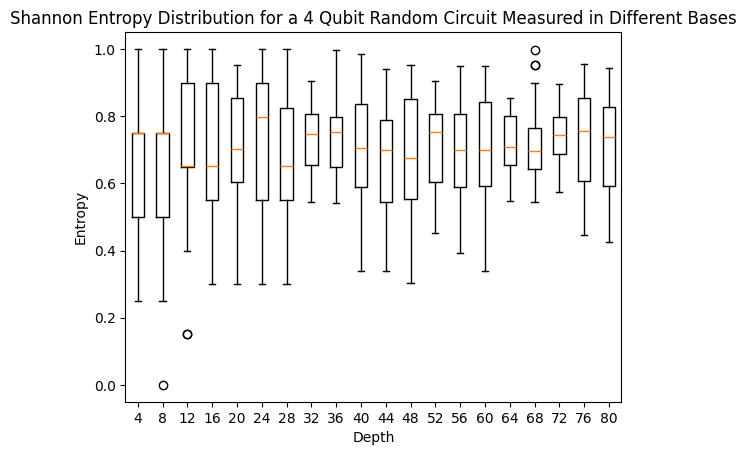

In [28]:
arr = []

with open('shadow_tomography_results_arr.pkl', 'rb') as file:
    arr = pickle.load(file)

df = pd.DataFrame(arr, columns=['Depth', 'Entropy'])
grouped_data = df.groupby('Depth')['Entropy'].apply(list).reset_index(name='Entropies')
data_to_plot = [row['Entropies'] for index, row in grouped_data.iterrows()]
fig, ax = plt.subplots()
ax.boxplot(data_to_plot)
ax.set_xticklabels(grouped_data['Depth'].astype(str))
ax.set_title('Shannon Entropy Distribution for a 4 Qubit Random Circuit Measured in Different Bases')
ax.set_xlabel('Depth')
ax.set_ylabel('Entropy')
plt.show()

**Interpretation:** This plot shows that the Shannon entropy, on average, does not fluctuate too much and stays pretty consistenly in the range 0.6-0.8 for circuits of all depths.